<a href="https://colab.research.google.com/github/SuriyaG09/Customer_Churn_analysis_in_Telecom/blob/main/Customer_Churn_analysis_in_Telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Telecom Customer Churn:

 Attributes in the dataset : customerID, gender, SeniorCitizen,	Partner,	Dependents,	tenure,	PhoneService,	MultipleLines,InternetService,	OnlineSecurity,	OnlineBackup,	DeviceProtection,	TechSupport,	StreamingTV,	StreamingMovies,	Contract,	PaperlessBilling,	PaymentMethod,	MonthlyCharges,	TotalCharges,	Churn

   
   Dataset is taken from Kaggle

In [1]:
# Importing neccessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter

# ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # for showing percentage in it

In [2]:
df = pd.read_csv('/content/dataset.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


From analysis of the dataset:

I noticed that some independent features are in numerical and most of feature are in categorical feature. Seperate into numerical and categorical data.

#### Separate into Numerical and Categorical feature

In [7]:
# Total charges are in object dtype so convert into Numerical feature
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
numerical_feature = {feature for feature in df.columns if df[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(numerical_feature)

Count of Numerical feature: 4
{'tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges'}


In [9]:
categorical_feature = {feature for feature in df.columns if df[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(categorical_feature)

Count of Categorical feature: 17
{'InternetService', 'gender', 'Churn', 'Partner', 'OnlineSecurity', 'StreamingMovies', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'PhoneService', 'customerID', 'PaymentMethod', 'TechSupport', 'PaperlessBilling', 'Contract', 'MultipleLines', 'Dependents'}


## Preliminary insights from the data

In [10]:
print("Count of Churn = ",df['Churn'].value_counts()['Yes'], "\nCount of non-churn = ",df['Churn'].value_counts()['No'])

Count of Churn =  1869 
Count of non-churn =  5174


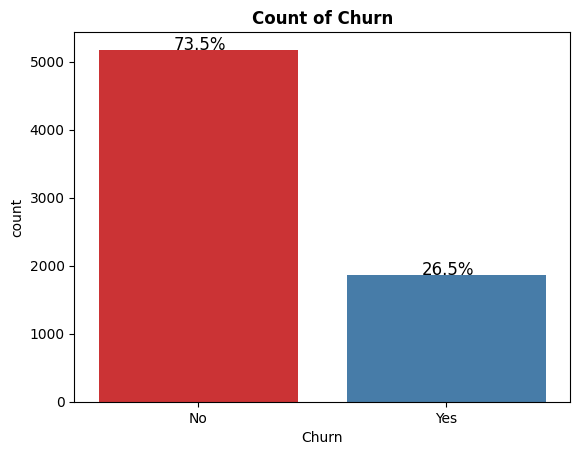

In [11]:
# Create a count plot using seaborn

color_palette = 'Set1'
ax = sns.countplot(data=df, x='Churn',palette=color_palette)

# Add a title to the plot
plt.title('Count of Churn', fontweight='bold')

# Calculate the percentage for each category
total = len(df['Churn'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=12)

# Show the plot
plt.show()


- key insight: 1869 customers left the service. Which is about 26.5 percentage from overall, this like an imbalance dataset

In [12]:
loss = []
for values in df.loc[df['Churn'] == 'Yes', 'TotalCharges']:
    value = float(values)
    loss.append(value)
print("Total loss - left churns: ",np.round(sum(loss)))

Total loss - left churns:  2862927.0


- Insight -> $ 2.86M Loss

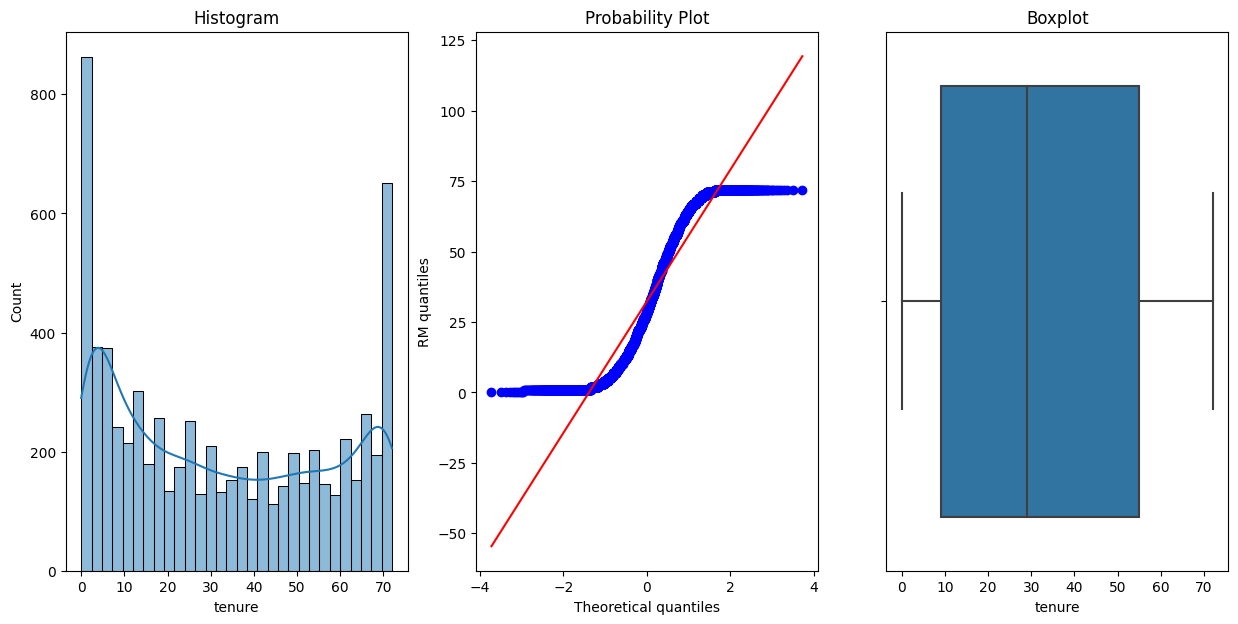

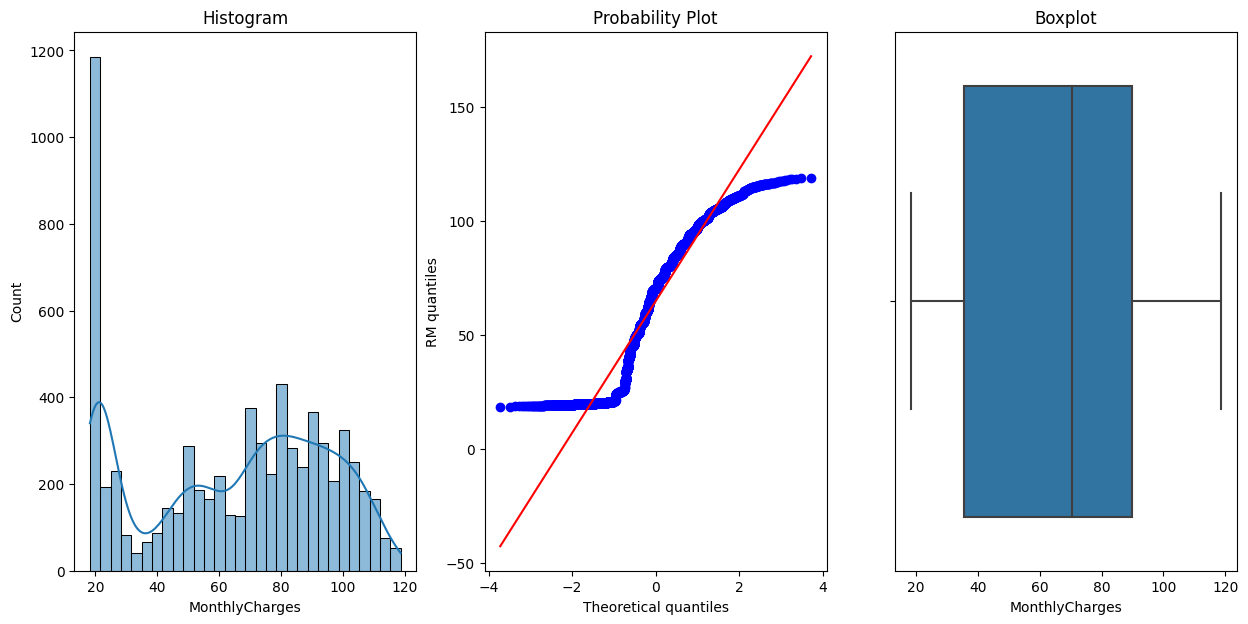

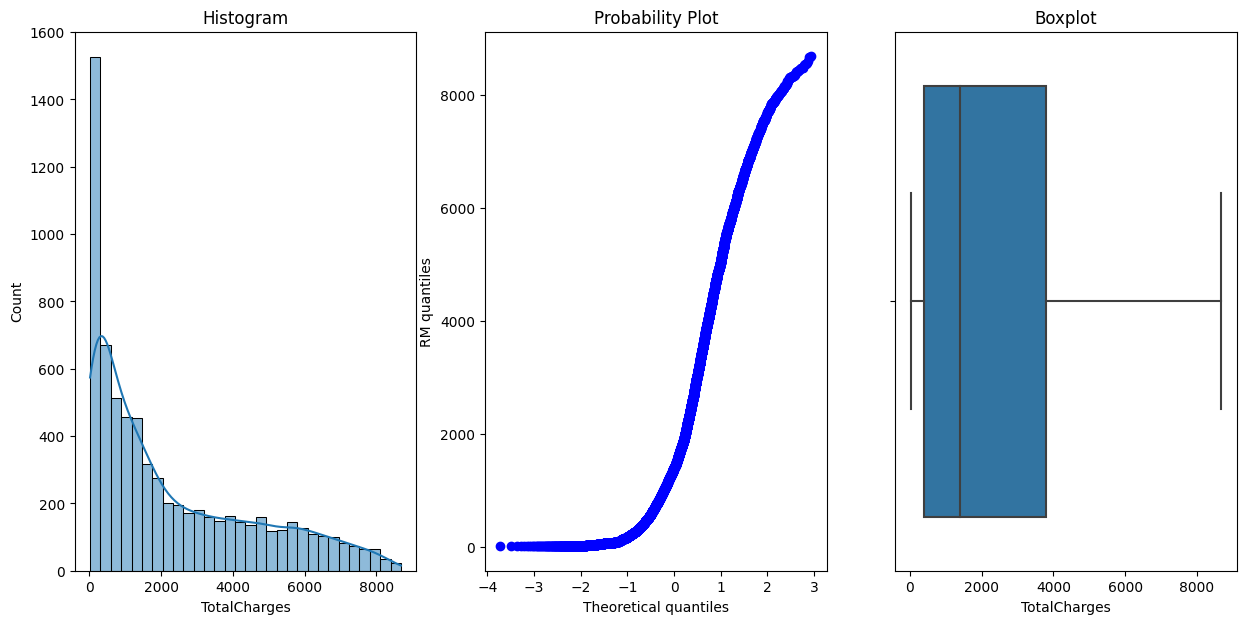

In [16]:
### Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(15,7))

        plt.subplot(1, 3, 1)
        sns.histplot(data=df, x=feature, bins=30, kde=True)
        plt.title('Histogram')

        plt.subplot(1, 3, 2)
        stats.probplot(df[feature], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')

        plt.subplot(1, 3, 3)
        sns.boxplot(x=df[feature])
        plt.title('Boxplot')

plt.show()

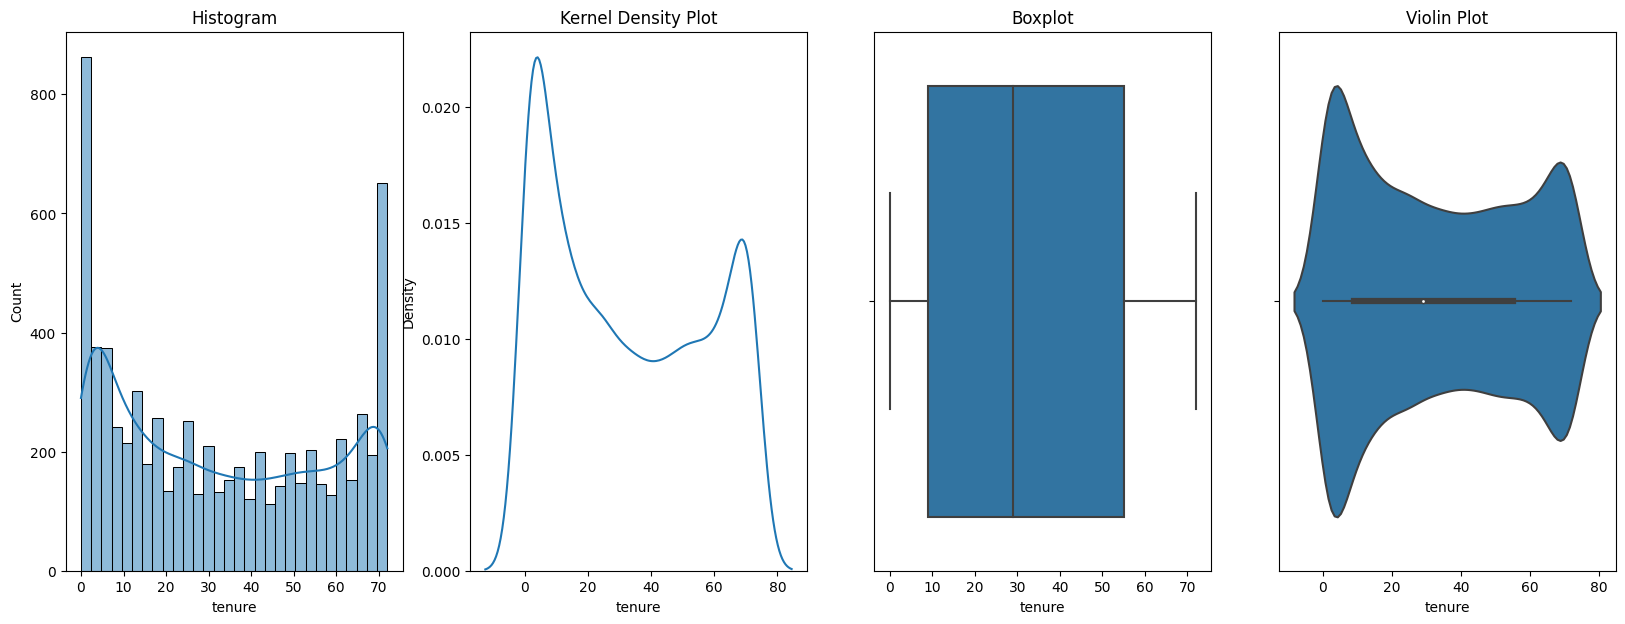

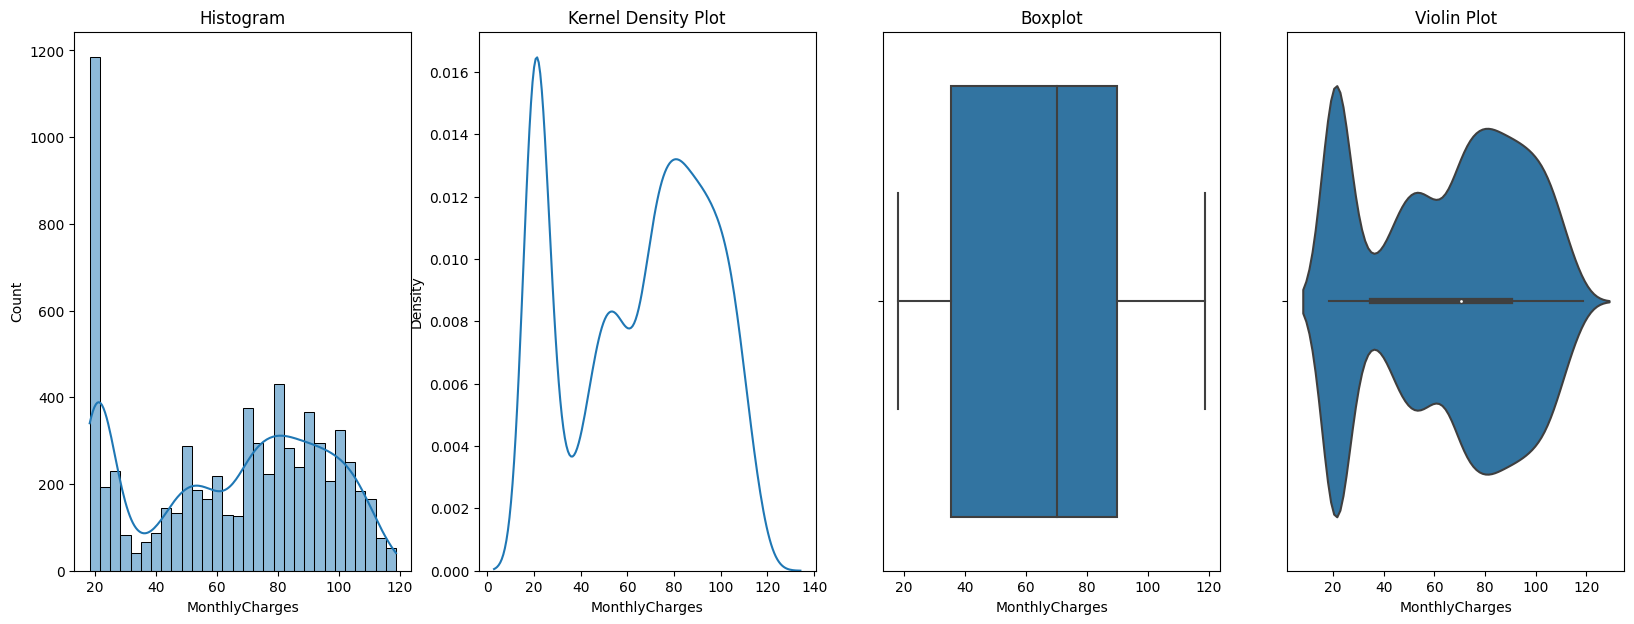

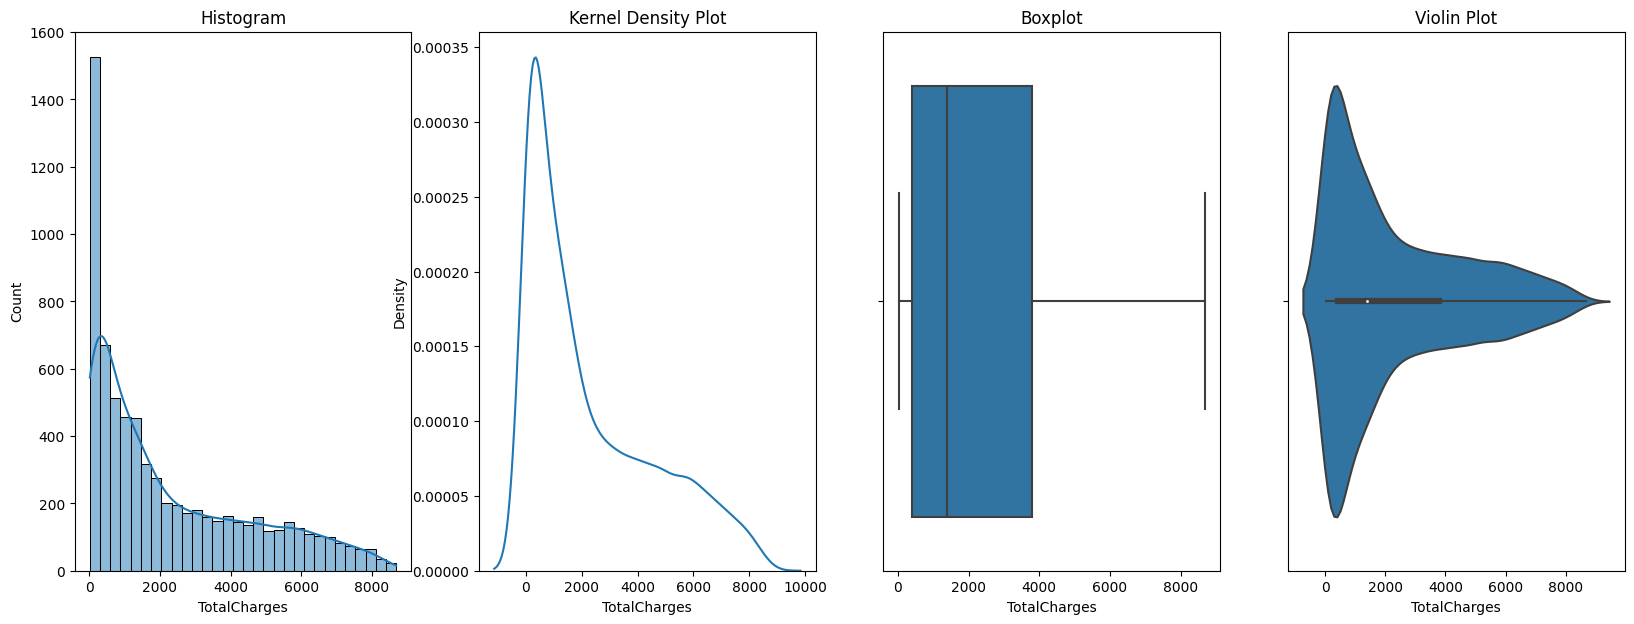

In [17]:
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(20, 7))

        plt.subplot(1, 4, 1)
        sns.histplot(data=df, x=feature, bins=30, kde=True)
        plt.title('Histogram')

        plt.subplot(1, 4, 2)
        sns.kdeplot(data=df, x=feature)
        plt.title('Kernel Density Plot')

        plt.subplot(1, 4, 3)
        sns.boxplot(x=df[feature])
        plt.title('Boxplot')

        plt.subplot(1, 4, 4)
        sns.violinplot(x=df[feature])
        plt.title('Violin Plot')

        plt.show()


- key insight is that we don't have any outliers

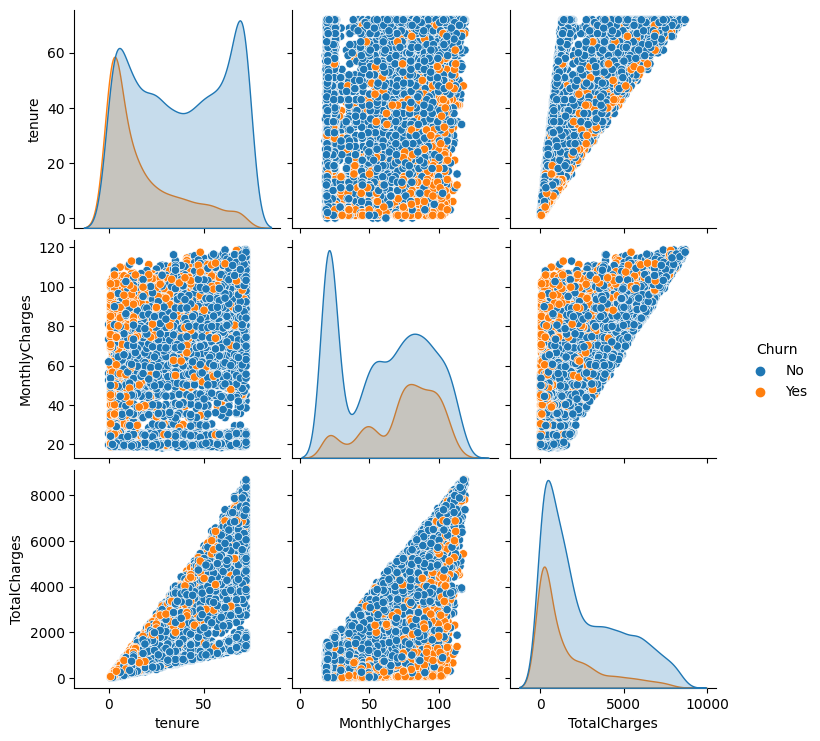

In [18]:
sns.pairplot(df.drop(columns='SeniorCitizen'),hue='Churn', kind='scatter')
plt.show()

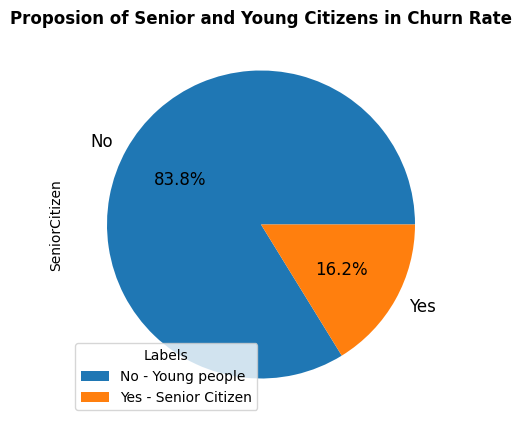

In [23]:
ax = (df['SeniorCitizen'].value_counts()*100.0 /len(df)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Proposion of Senior and Young Citizens in Churn Rate', fontsize = 12, fontweight='bold')
ax.legend(title='Labels', labels=['No - Young people', 'Yes - Senior Citizen'], loc='lower left')
plt.show()

Only 16.2% customers who are senior citizons but remaining 83.8% customers are young people

## Relevancy of the categorical data in the churn rate ??

<Figure size 640x480 with 0 Axes>

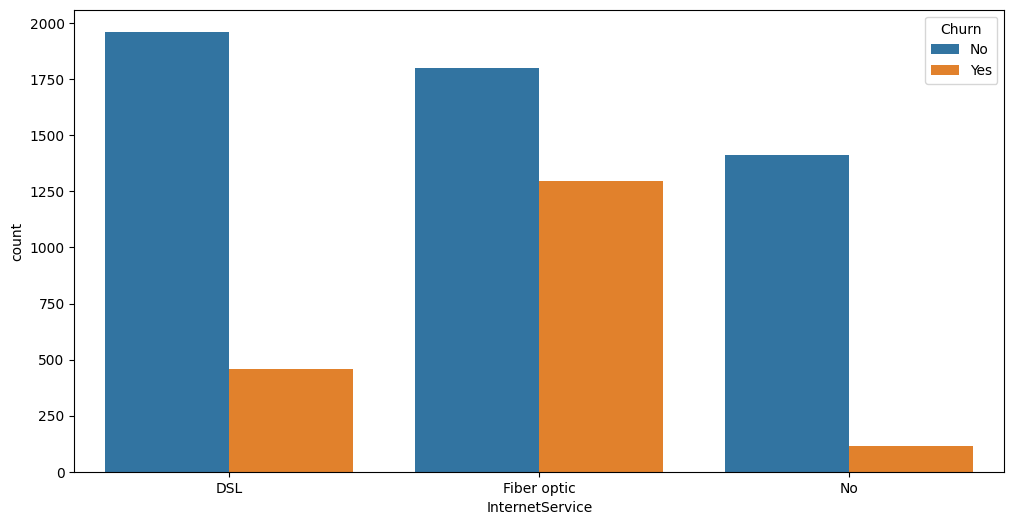

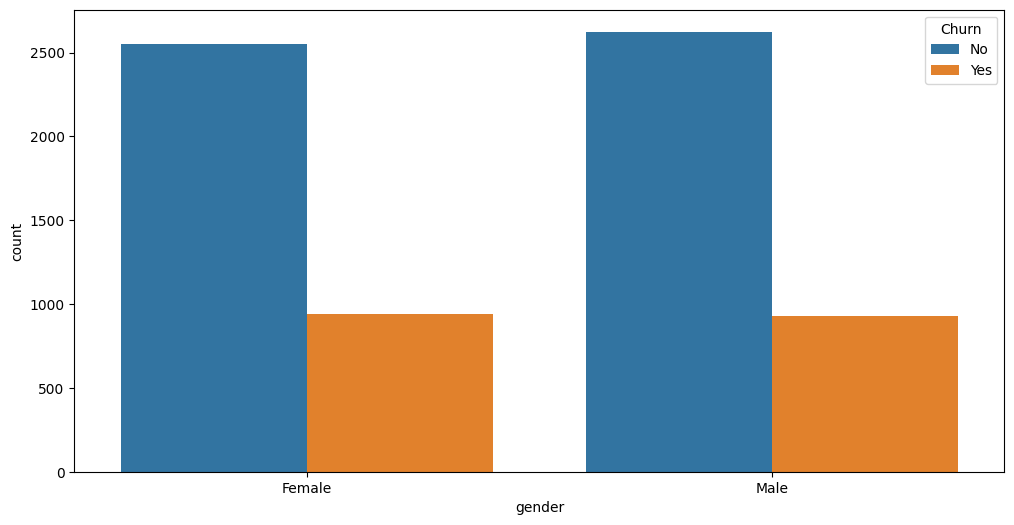

<Figure size 640x480 with 0 Axes>

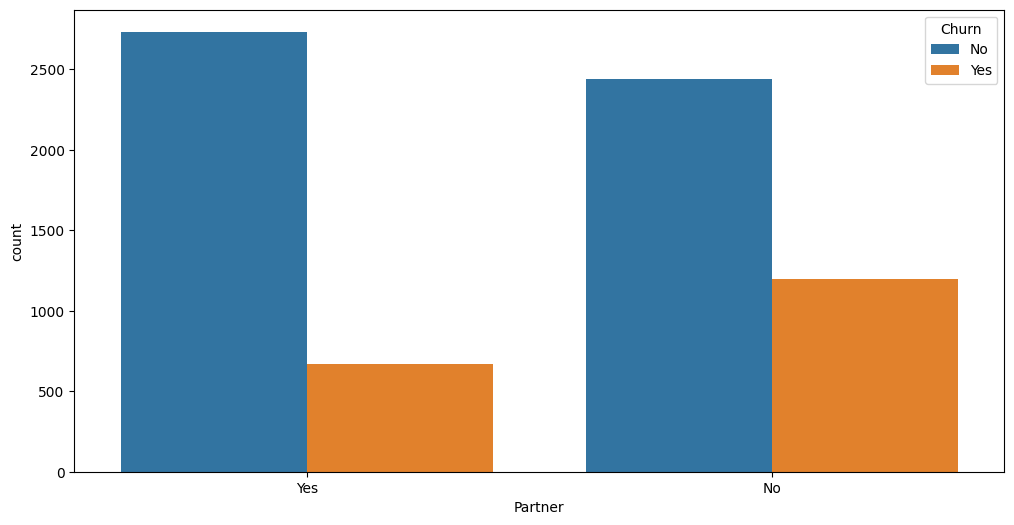

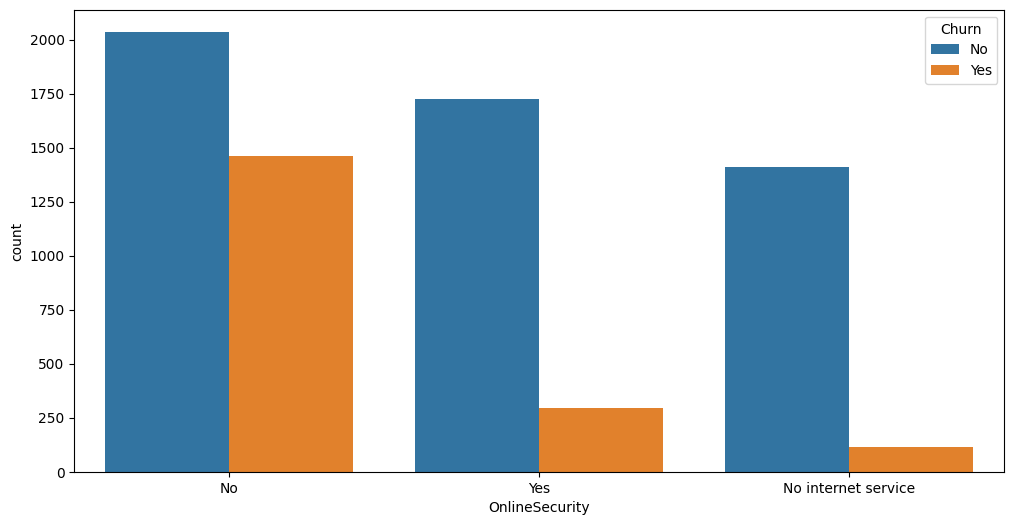

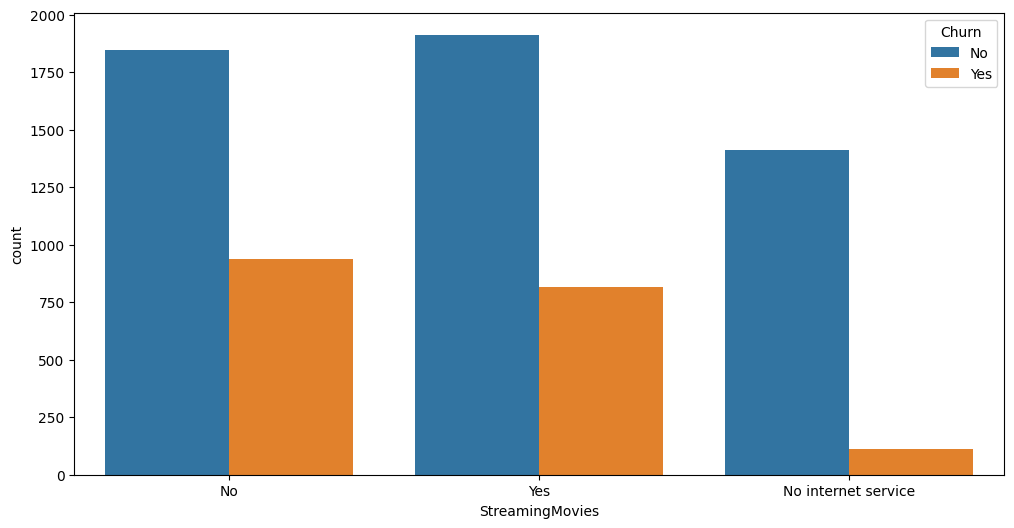

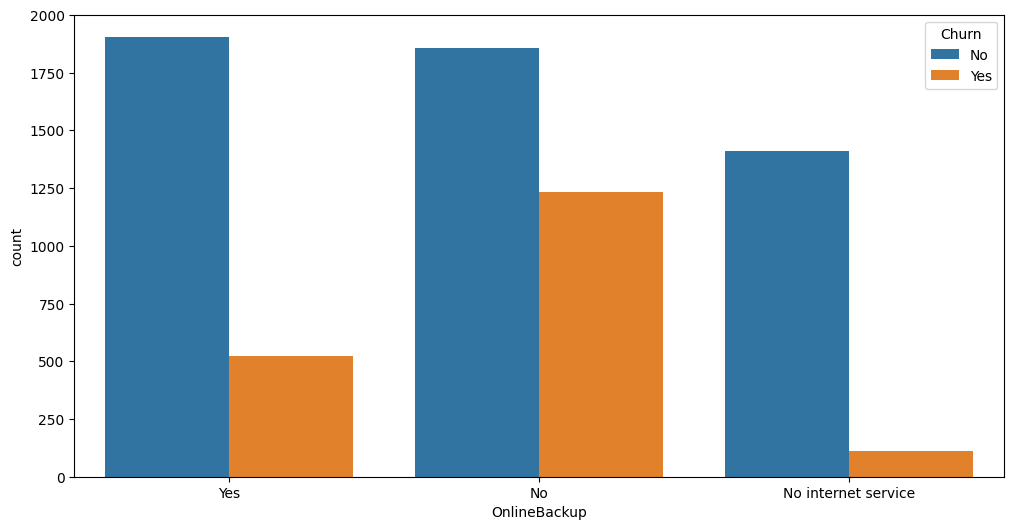

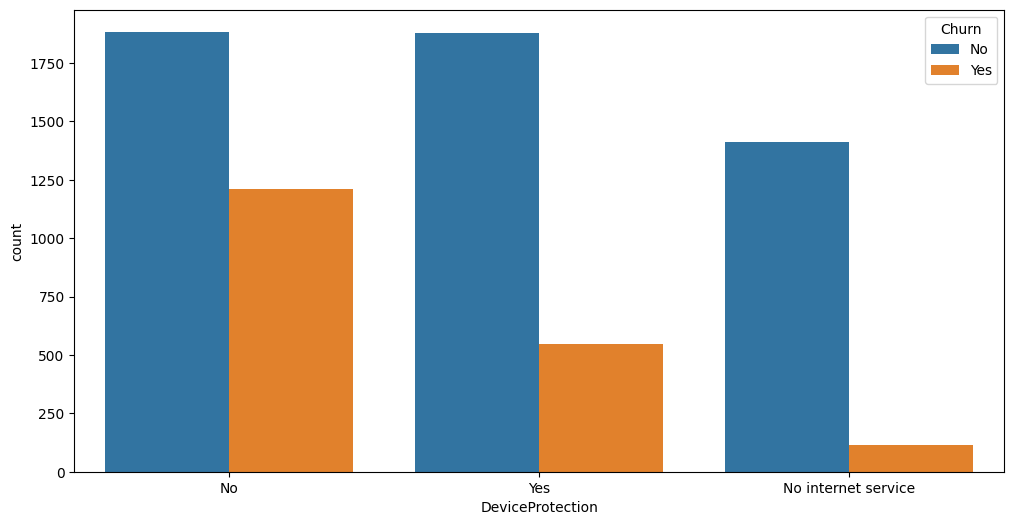

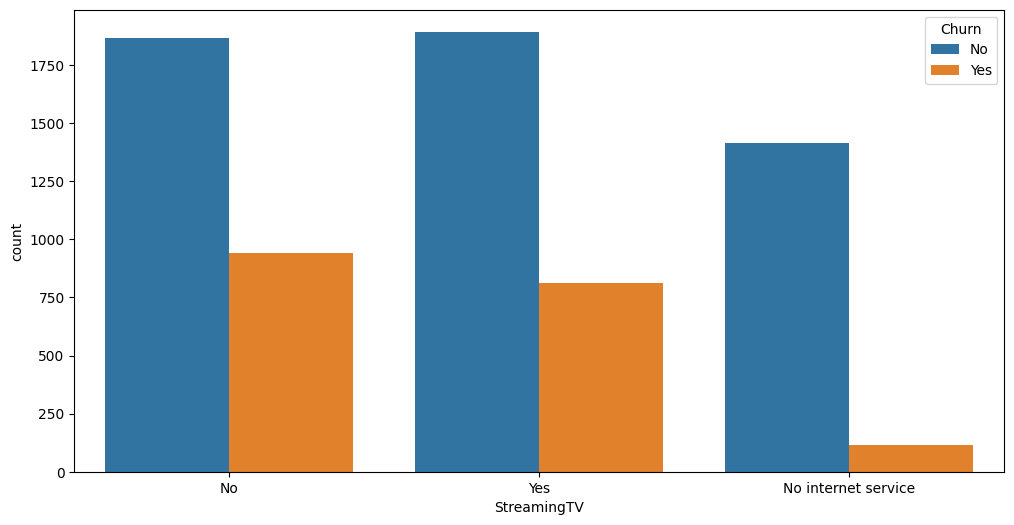

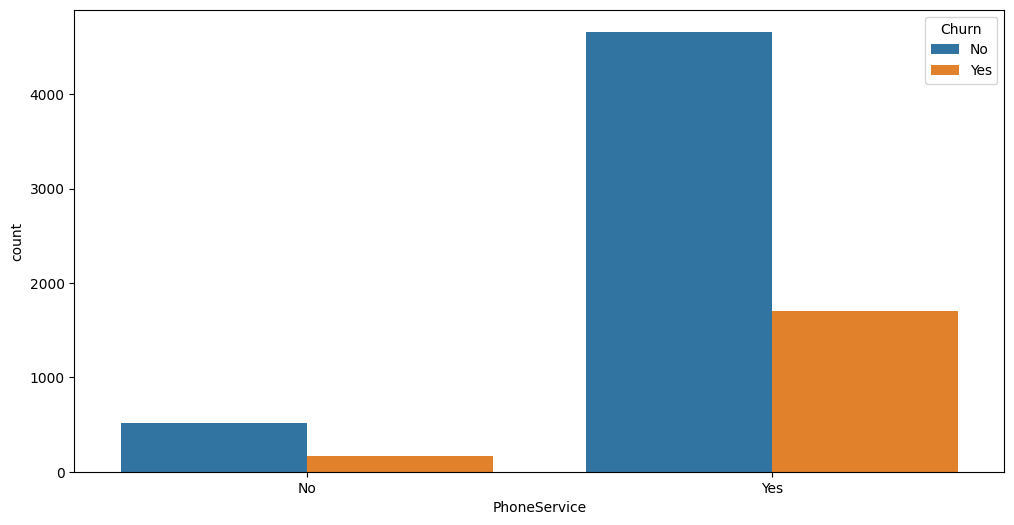

<Figure size 640x480 with 0 Axes>

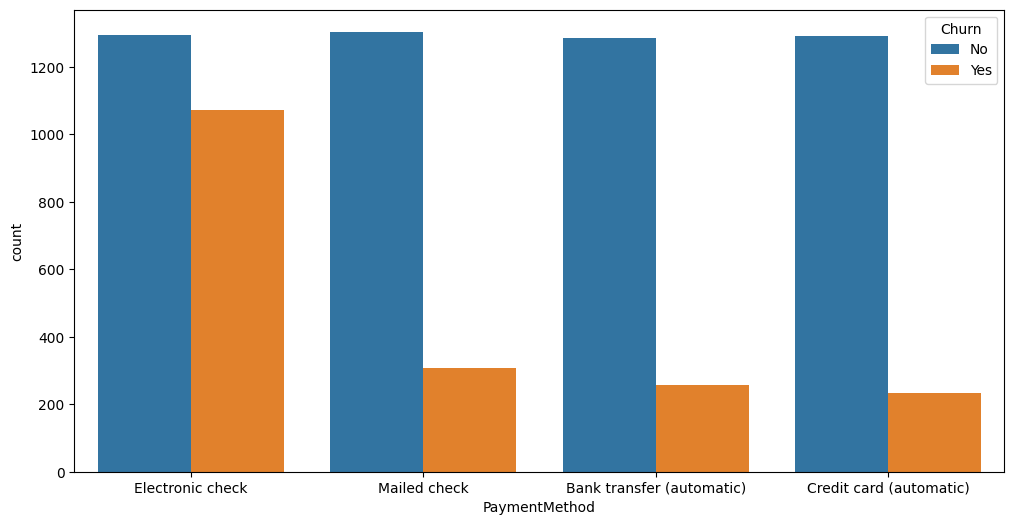

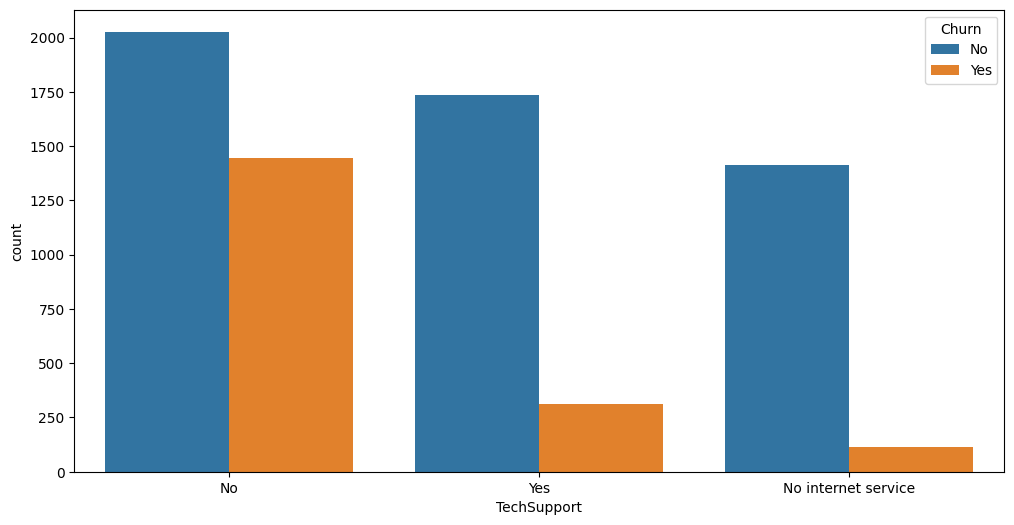

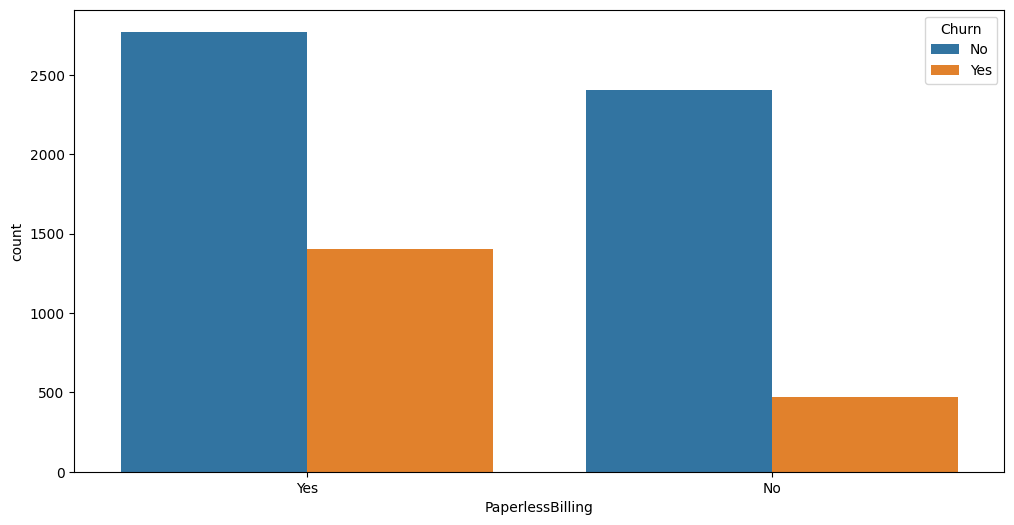

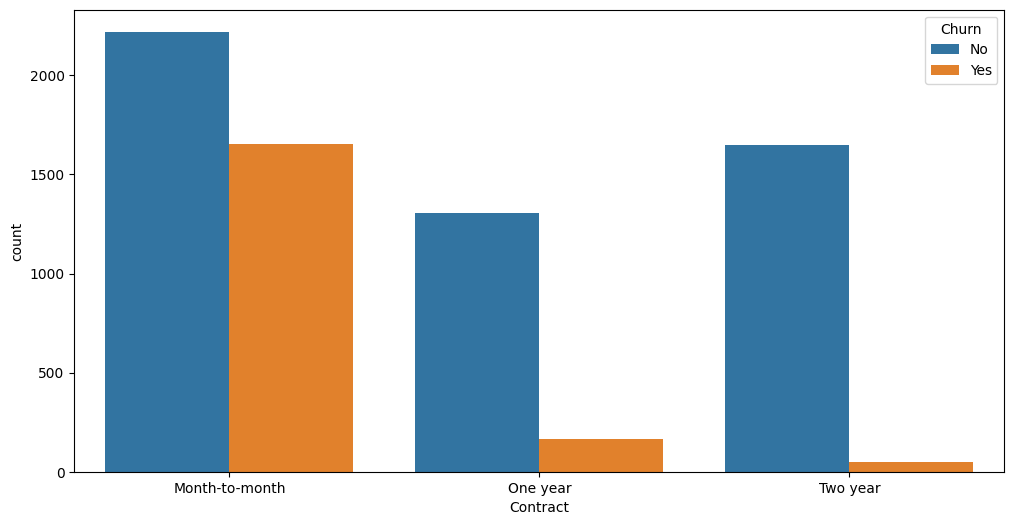

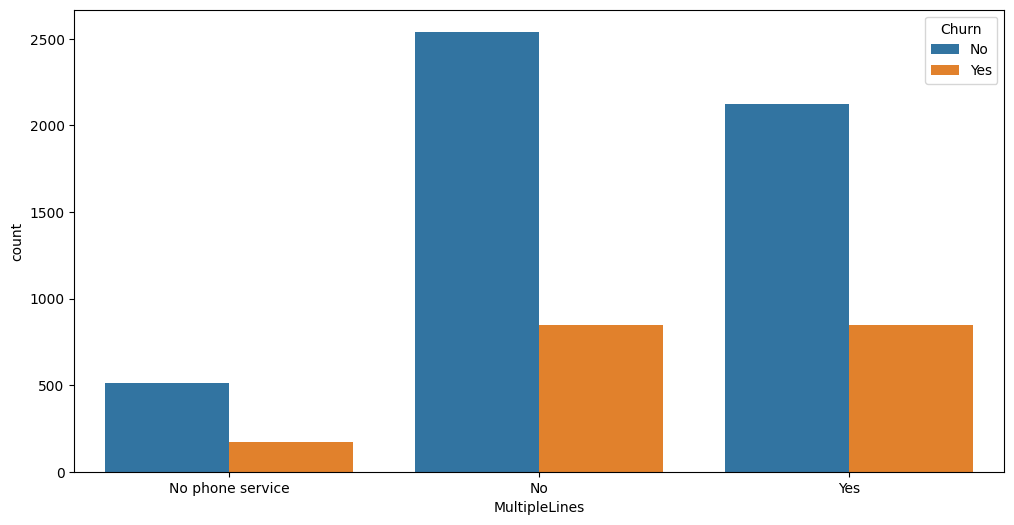

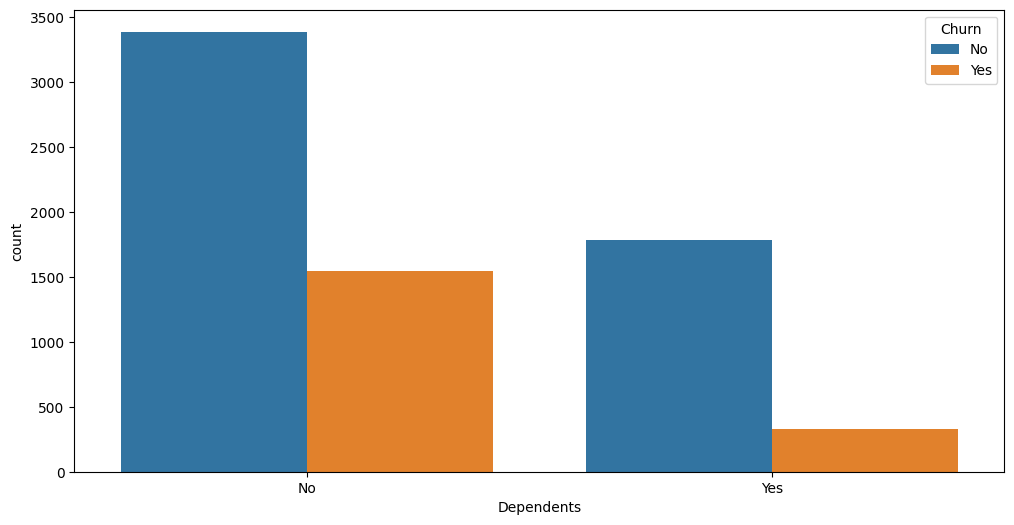

In [25]:
for i, feature in enumerate(categorical_feature):
    if feature != 'TotalCharges':
        if feature != 'customerID':
          if feature != 'Churn':
              plt.figure(i)
              plt.figure(figsize=(12,6))
              sns.countplot(data=df, x=feature, hue='Churn')
plt.show()

## Data Cleaning

In [26]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

totalCharges is having 11 null values. so fill the null values with mean value of the column

In [27]:
df.TotalCharges = df.TotalCharges.fillna(df.TotalCharges.mean())

<Axes: >

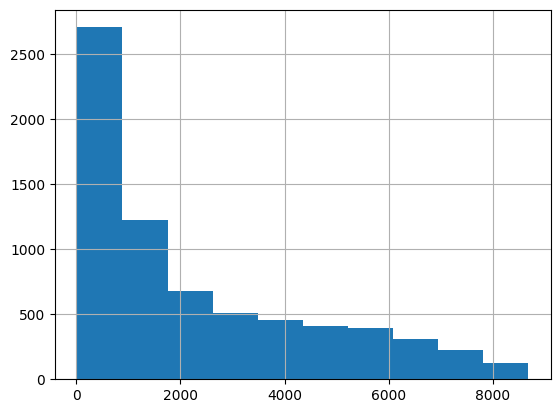

In [28]:
df.TotalCharges.hist()

null valus has been removed and label encoder have to be used to categorical features

In [29]:
print(categorical_feature)

{'InternetService', 'gender', 'Churn', 'Partner', 'OnlineSecurity', 'StreamingMovies', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'PhoneService', 'customerID', 'PaymentMethod', 'TechSupport', 'PaperlessBilling', 'Contract', 'MultipleLines', 'Dependents'}


In [30]:
encoder = LabelEncoder()
for feature in categorical_feature:
    df[feature] = encoder.fit_transform(df[feature])

In [31]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [32]:
df.drop(columns=['customerID'], inplace=True)

In [33]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Correlation of churn with all the features

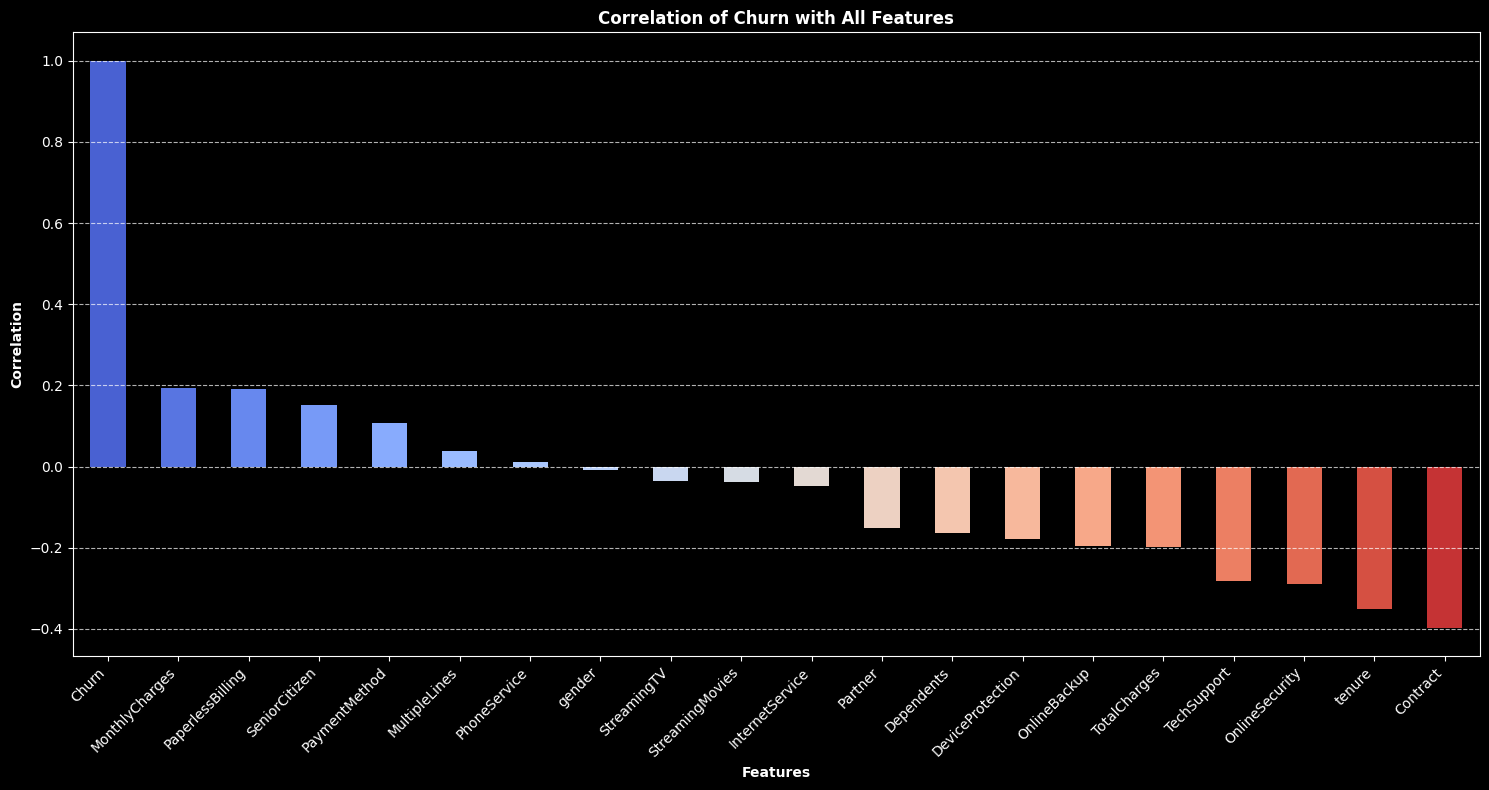

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set dark background style
plt.style.use('dark_background')

plt.figure(figsize=(15, 8))

correlation_order = df.corr()['Churn'].sort_values(ascending=False)

# Generating a gradient of colors
colors = sns.color_palette("coolwarm", len(correlation_order))

# Create the bar plot with colored bars
ax = correlation_order.plot(kind='bar', color=colors)

# Set plot title and labels
plt.title('Correlation of Churn with All Features', fontweight='bold', color='white')
plt.xlabel('Features', fontweight='bold',color='white')
plt.ylabel('Correlation', fontweight='bold',color='white')

# Rotate x-axis labels for better readability
ax.set_xticklabels(correlation_order.index, rotation=45, ha='right', color='white')

# Set y-axis labels color to white
ax.yaxis.label.set_color('white')

# Display grid lines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Set color of tick labels on x and y axes
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.tight_layout()
plt.show()


Heatmap

<Axes: >

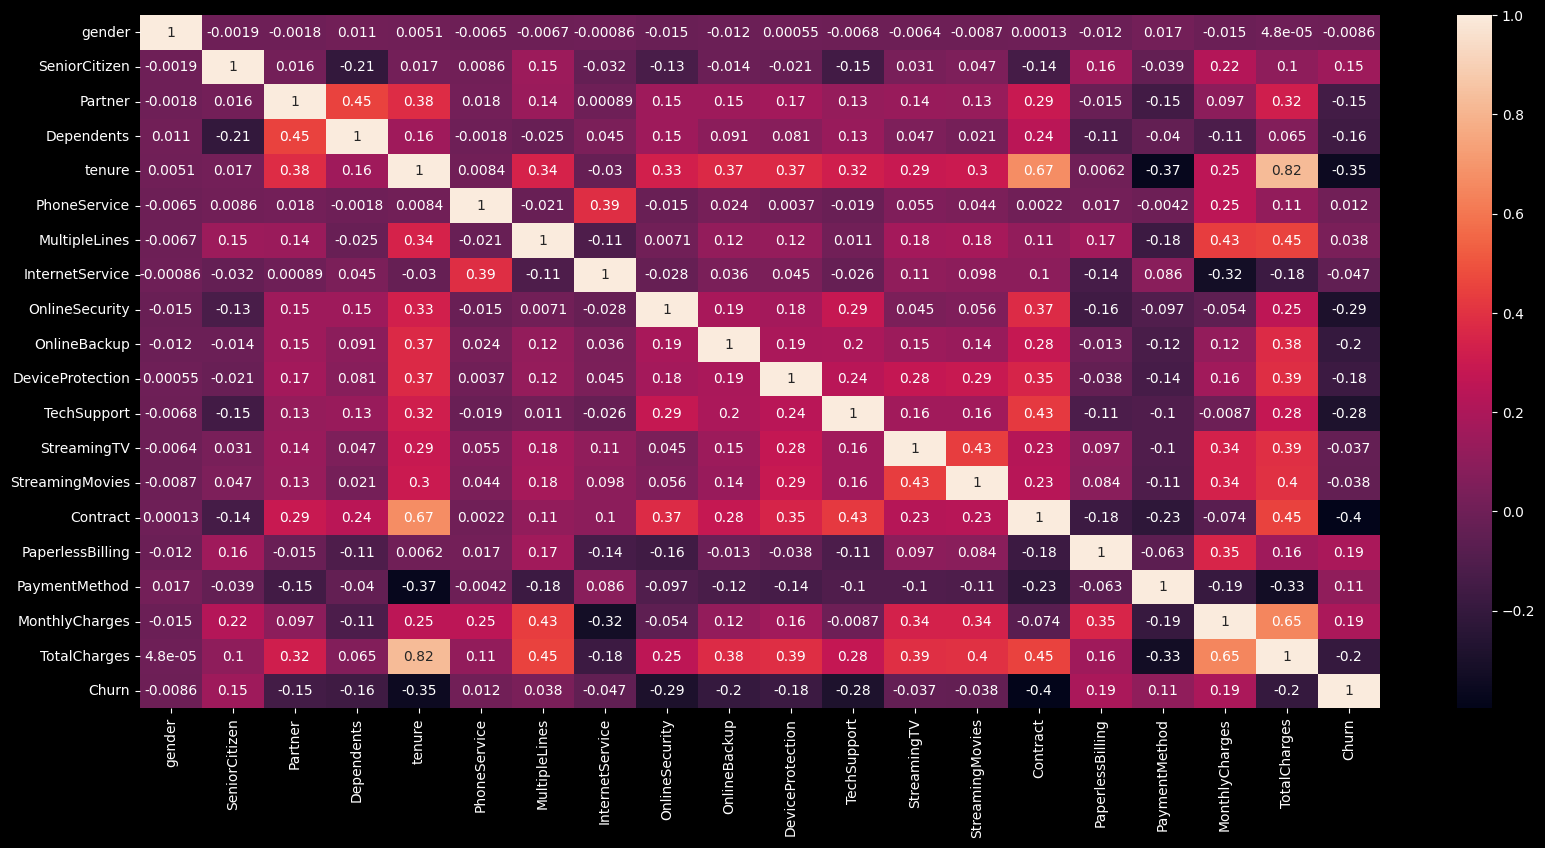

In [46]:
# Finding the correlation between the independent and dependent feature
plt.figure(figsize=(20, 9))
sns.heatmap(df.corr(), annot=True)

## Training

#### Splitting the dataset into train and test

In [47]:
X = df.drop(columns='Churn')
y = df['Churn']

- Selecting top 10 features with higher correlation

In [49]:
selection = SelectKBest()  # k=10 default
X = selection.fit_transform(X,y)

In [50]:
#  this will shows which feature are taken denote as True other are removed like false
selection.get_support()

array([False, False, False,  True,  True, False, False, False,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True])

###10 out of 21 features are selected based on the top 10 cor-relation value.
    Dependents, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges, TotalCharges

In [51]:
# splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [52]:
X_train.shape

(5634, 10)

In [53]:
X_test.shape

(1409, 10)

In [54]:
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

###The ML Algo used :
    1. Logistic Regression
    2. RandomForest Classifier
    3. DecisionTree Classifier
    4. GradientBoosting Classifier

1. Logistic Regression

In [55]:
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.8069552874378992
Confusion matrix :
 [[928 148]
 [124 209]]
Classification report :
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1076
           1       0.59      0.63      0.61       333

    accuracy                           0.81      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.81      0.81      0.81      1409



2. Random forest classifier

In [56]:
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.8211497515968772
Confusion matrix :
 [[964 164]
 [ 88 193]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      1128
           1       0.54      0.69      0.61       281

    accuracy                           0.82      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.84      0.82      0.83      1409



3. DecisionTree Classifier

In [ ]:
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7885024840312278
Confusion matrix :
 [[956 206]
 [ 92 155]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.82      0.87      1162
           1       0.43      0.63      0.51       247

    accuracy                           0.79      1409
   macro avg       0.67      0.73      0.69      1409
weighted avg       0.83      0.79      0.80      1409



As I compare to the imbalance dataset our model are perform like okay not a better model to build for end to end project. Need to over sampling data for reducing the TN, FN and increase the FP and TP for model building

### Using SMOTEENN for imbalance dataset
     Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [57]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 4122, 1: 1512})
The number of classes after fit Counter({1: 2429, 0: 2063})


In [58]:
# splitting the over sampling dataset
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [59]:
# decisionTree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9299221357063404
Confusion matrix :
 [[377  23]
 [ 40 459]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       400
           1       0.95      0.92      0.94       499

    accuracy                           0.93       899
   macro avg       0.93      0.93      0.93       899
weighted avg       0.93      0.93      0.93       899



In [60]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9488320355951056
Confusion matrix :
 [[391  20]
 [ 26 462]]
Classification report :
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       411
           1       0.96      0.95      0.95       488

    accuracy                           0.95       899
   macro avg       0.95      0.95      0.95       899
weighted avg       0.95      0.95      0.95       899



In [61]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.9087875417130145
Confusion matrix :
 [[379  44]
 [ 38 438]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       423
           1       0.91      0.92      0.91       476

    accuracy                           0.91       899
   macro avg       0.91      0.91      0.91       899
weighted avg       0.91      0.91      0.91       899



In [62]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9555061179087876
Confusion matrix :
 [[395  18]
 [ 22 464]]
Classification report :
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       413
           1       0.96      0.95      0.96       486

    accuracy                           0.96       899
   macro avg       0.95      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899



After using SMOOTEENN methods to perform over sampling and down sampling with edited nearest neighbours. From this results we get bet accuraccy and TP FP ratio also increases in GradientBoostClassifier so perform HyperParameter Tunning for this model only

In [63]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [64]:
gbc_optm = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid,n_iter=100, verbose=3)
gbc_optm.fit(X_train_sap, y_train_sap)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=mse, learning_rate=0.5, loss=deviance, max_depth=3, max_leaf_nodes=18, min_samples_leaf=13, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.5, loss=deviance, max_depth=3, max_leaf_nodes=18, min_samples_leaf=13, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.5, loss=deviance, max_depth=3, max_leaf_nodes=18, min_samples_leaf=13, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.5, loss=deviance, max_depth=3, max_leaf_nodes=18, min_samples_leaf=13, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.5, loss=deviance, max_depth=3, max_leaf_nodes=18, min_samples_leaf=13, min_samples_split=7, n_estimators=300;, score=nan total time=   0.0s
[CV 1/5] END crit

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_leaf_nodes': [3, 6, 8, 9, 12, 15,
                                                           18, 24],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   verbose=3)

In [65]:
gbc_optm.best_estimator_

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=17,
                           max_leaf_nodes=18, min_samples_split=4)

In [66]:
# GradientBoostingClassifier
gbc_tunning = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.3,
                           max_depth=19, max_leaf_nodes=24, min_samples_leaf=9,
                           min_samples_split=7, n_estimators=150)
gbc_tunning.fit(X_train_sap, y_train_sap)
pred = gbc_tunning.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9710789766407119
Confusion matrix :
 [[398   7]
 [ 19 475]]
Classification report :
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       405
           1       0.99      0.96      0.97       494

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899



After Oversampling the dataset our model performs is pretty good. From our 4 model **GradientBoostClassifier** performs better than all. So we dumb our model using pickle library

#### **Model Saving:**

In [67]:
import pickle

In [68]:
filename = 'Model.sav'
pickle.dump(gbc_tunning, open(filename,'wb'))

In [69]:
load_model = pickle.load(open(filename, 'rb'))

In [70]:
load_model.score(X_test_sap, y_test_sap)

0.9710789766407119

In [71]:
Dependents = 'Yes'
tenure = 1
OnlineSecurity = 'No'
OnlineBackup = 'Yes'
DeviceProtection = 'No'
TechSupport = 'No'
Contract = 'Month-to-month'
PaperlessBilling = 'No'
MonthlyCharges = 29.85
TotalCharges = 556.85

In [72]:
data = [[Dependents, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges, TotalCharges]]

In [74]:
df = pd.DataFrame(data, columns=['Dependents', 'tenure', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
        'PaperlessBilling', 'MonthlyCharges', 'TotalCharges'])
df.head()
print(df.dtypes)

Dependents           object
tenure                int64
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
MonthlyCharges      float64
TotalCharges        float64
dtype: object


In [73]:
for feature in df.columns:
    if df[feature].dtypes == 'O':
        categorical_feature = feature
        print(categorical_feature)

In [75]:
encoder = LabelEncoder()
for feature in df.columns:
    if df[feature].dtypes == 'O':
        df[feature] = encoder.fit_transform(df[feature])

In [ ]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,TotalCharges
0,0,1,0,0,0,0,0,0,29.85,556.85


In [76]:
single = load_model.predict(df)
probability = load_model.predict_proba(df)[:,1]

In [77]:
print(single)

[0]


In [78]:
print(probability)

[0.31291022]


In [79]:
if single == 1:
    print("This Customer is likely to be Churned!")
    print(f"Confidence level is {np.round(probability*100, 2)}")
else:
    print("This Customer is likely to be Continue!")
    print(f"Confidence level is {np.round(probability*100, 2)}")

This Customer is likely to be Continue!
Confidence level is [31.29]
